## Modules importation 

- **SERS_ML_tools:** Module that defines a set of classes and functions that will be used to apply machine learning on SERS spectra.  
- **SERS_ML_models:** Module that contains templates of different machine learning models that have been designed for easier and more efficient implementation with SERS spectra. 
    

In [ ]:
import pandas as pd
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os

from spec_master.utility import data_split, plot_distribution, spectro_plot, random_plot, database_creator
from spec_master.spectro_augmentation import SpectralDataAug as SpecDA
from spec_master.pca_model import SpectroPCA
from spec_master.spectro_correction import baseline_subtraction, savgol_smoothing, spectral_normalization
from spec_master.deep_models import SpectroCNN

## Building the SERS spectra Database

#### Retrieving important information from SERS .txt files

- To create a database, SERS .txt files must be placed in the same folder, and follow the following format: 
    - first column = wavelenght or Raman shift 
    - other columns = one spectra per column 
- In this experiment, two databases are created before being combined together 

In [ ]:
# directory containing txt files of SERS spectra taken on June 10, 2020
directory_a = "data/bile_acid_10_06_2020/"
# extracting from the directory all txt file names in alphabetical order
filenames_a = [f for f in os.listdir(directory_a) if f.endswith(".txt")]  # order = blanck , ca ,dca, gca, lca, tca
# definition of a list containing the class names in the order of appearance in filenames_a
classnames_a = ['Blank', 'CA', 'DCA', 'GCDCA', 'LCA', 'TCDCA']
# number of files/class in order of appearance in filenames_a
nfiles_class_a = [3, 3, 3, 3, 3, 3]

# directory containing txt files of SERS spectra taken on June 12, 2020
directory_b = "data/bile_acid_12_06_2020/"
# extracting from the directory all txt file names in alphabetical order
filenames_b = [f for f in os.listdir(directory_b) if f.endswith(".txt")]  # order = ca ,dca, gca, lca, tca
# definition of a list containing the class names in the order of appearance in filenames_b
classnames_b = ('CA', 'DCA', 'GCDCA', 'LCA', 'TCDCA')  # class name in order of appearance in files_a
# number of files/class in order of appearance in filenames_b
nfiles_class_b = [2, 2, 2, 2, 2]

#### Database building using the information just retrieved 

- To save the database : data.to_pickle('name.pkl')
- to load the database : data = pd.read_pickle('name.pkl')

In [ ]:
# creating two sub-databases
data_a, Wn = database_creator(directory_a, filenames_a, classnames_a, nfiles_class_a)
data_b, Wn = database_creator(directory_b, filenames_b, classnames_b, nfiles_class_b)
# concatenation of the two sub-databases to form the main database
data = pd.concat([data_a, data_b], ignore_index=True)
# takes the blank's class out and  reset index 
data = data[data.Classes != 'Blank'].reset_index(drop=True)
# as the 'Blank' class no longer exists in data, classnames_b list is better suited to define the class names.
classnames = classnames_b

data  # print the database

## Extracting spectra and labels and splitting into training, validation and test subsets 

In [4]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# encodes class names as integer labels: [0] [4] [1] ...
data['Classes'] = labelencoder.fit_transform(data['Classes'])

# takes the labels from the database and stores them as a numpy array(int).
lab = data.to_numpy(dtype='int')[0:, 0]
# converts labels to a binary matrix [1 0 0 0] [0 0 0 4] [0 1 0 0]
lab_enc = np_utils.to_categorical(lab)

# takes the spectra from the database and stores them as a numpy array(float64).  
spectra = data.to_numpy(dtype='float64')[0:, 1:]

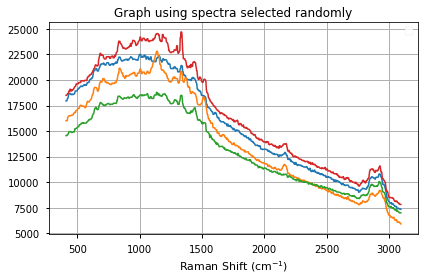

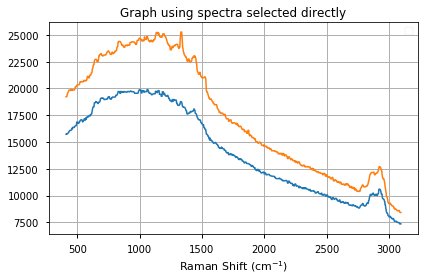

In [5]:
random_plot(Wn, spectra, title='Graph using spectra selected randomly', random_spectra=4)
spectro_plot(Wn, spectra[0], spectra[670], title='Graph using spectra selected directly')

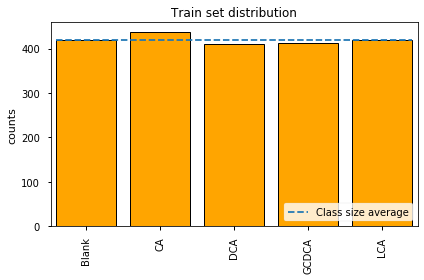

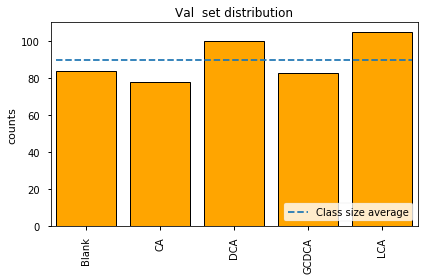

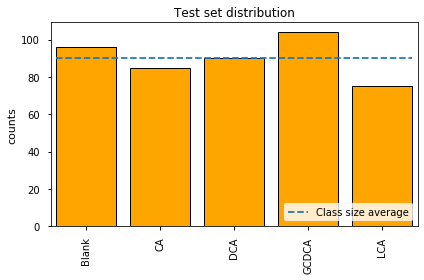

In [6]:
(x_train, x_val_test, y_train, y_val_test) = data_split(spectra, lab_enc, b_size=0.3, rdm_ste=6)
(x_val, x_test, y_val, y_test) = data_split(x_val_test, y_val_test, b_size=0.5, rdm_ste=10)

plot_distribution(y_train, title='Train set distribution', class_names=classnames_a)
plot_distribution(y_val, title='Val  set distribution', class_names=classnames_a)
plot_distribution(y_test, title='Test set distribution', class_names=classnames_a)

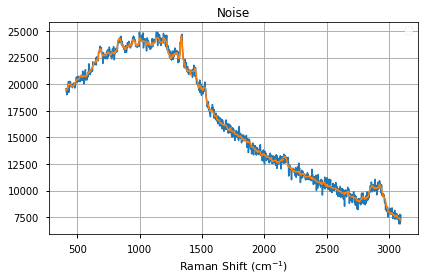

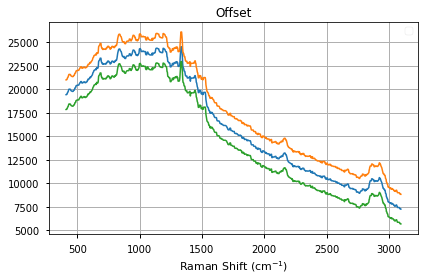

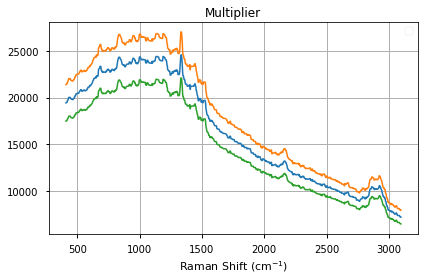

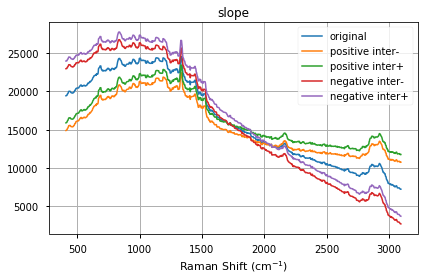

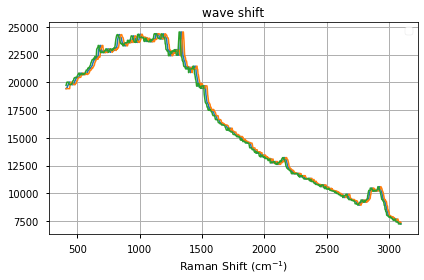

In [7]:
# A spectrum of the training set is selected
x_sample = x_train[1200]  # index =5
# Determination of the average intensity value of this spectrum.
mean_sample = np.mean(x_sample)

# Parameter that can or should be changed
param_nse = 0.02
param_ioff = 0.1
param_mult = 0.1
param_slp = 0.0005
param_inter = 500
param_wshft = 5

# Noise additon
x_nse = SpecDA.noise_addition(x_sample, mean_sample*param_nse)
spectro_plot(Wn, x_nse, x_sample, title='Noise')

# Intensity Offset
off_sup = SpecDA.ioffset(x_sample, param_ioff*mean_sample)
off_inf = SpecDA.ioffset(x_sample, -param_ioff*mean_sample)
spectro_plot(Wn, x_sample, off_sup, off_inf, title='Offset')

# Multipier
mult_sup = SpecDA.multiplier(x_sample, 1 + param_mult)
mult_inf = SpecDA.multiplier(x_sample, 1 - param_mult)
spectro_plot(Wn, x_sample, mult_sup, mult_inf, title='Multiplier')

# Linear slope
slp_supa = SpecDA.linear_slope(x_sample, param_slp*mean_sample, -param_inter)
slp_supb = SpecDA.linear_slope(x_sample, param_slp*mean_sample, param_inter)
slp_infa = SpecDA.linear_slope(x_sample, -param_slp*mean_sample, -param_inter)
slp_infb = SpecDA.linear_slope(x_sample, -param_slp*mean_sample, param_inter)
leg = ('original', 'positive inter-', 'positive inter+', 'negative inter-', 'negative inter+')
spectro_plot(Wn, x_sample, slp_supa, slp_supb, slp_infa,  slp_infb, legend=leg, title='slope')

# Wavelenght shift
wshft_sup = SpecDA.wshift(x_sample, param_wshft)
wshft_inf = SpecDA.wshift(x_sample, -param_wshft)
spectro_plot(Wn, x_sample, wshft_sup, wshft_inf, title='wave shift')

In [8]:
# determining the average for each spectra contained in the training set
xtrain_mean = np.mean(x_train, axis=1, keepdims=True)
i = 2  # number of iterations

# creating instance of SpecDA
data_aug_pipeline = SpecDA(x_train, y_train)
# each following line corresponds to a data augmentation method which can be omitted by adding a "#" 
# in front of the line
data_aug_pipeline.aug_noise(param_nse, iterations=i)
data_aug_pipeline.aug_ioffset(param_ioff*xtrain_mean, iterations=i)
data_aug_pipeline.aug_multiplier(param_mult, iterations=i)
data_aug_pipeline.aug_linear_slope(param_slp*xtrain_mean, param_inter, iterations=i)
data_aug_pipeline.aug_wshift(param_wshft, iterations=i)
data_aug_pipeline.aug_mixup(n_spec=3, alpha=0.35, iterations=3)

# retrieving augmented data
x_train_aug, y_train_aug = data_aug_pipeline.out()
print('x_train before/after shapes =', x_train.shape,'/', x_train_aug.shape)
print('y_train before/after shapes =', y_train.shape,'/', y_train_aug.shape)


x_train before/after shapes = (2100, 1024) / (29400, 1024)
y_train before/after shapes = (2100, 5) / (29400, 5)


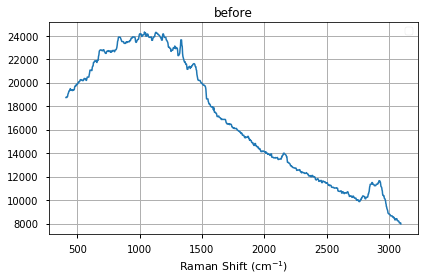

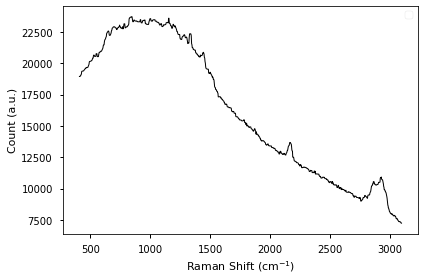

In [9]:
BC_lam = 10000
BC_p = 0.001
BC_niter = 5
window_length = 9  # Odd number that starts at 5
i_start = 520
i_end = 860

new = np.linspace(500, 3000, 1000)


def preprocessing_pipeline(x_prep, w_prep):

    # x_prep, _ = spline_interpolation(x_prep, Wn, new)
    # _, x_prep = baseline_subtraction(x_prep, lam=BC_lam, p=BC_p, niter=BC_niter)
    #x_prep = savgol_smoothing(x_prep, 7, p=3)
    #x_prep = spectral_normalization(x_prep)
    return x_prep, w_prep


x_train_prep, Wn_prep = preprocessing_pipeline(x_train_aug, Wn)
x_val_prep, Wn_prep = preprocessing_pipeline(x_val, Wn)
x_test_prep, Wn_prep = preprocessing_pipeline(x_test, Wn)


spectro_plot(Wn, x_test[12], title='before')
spectro_plot(Wn_prep, x_test_prep[21], col='k', line_w=1, ylabel='Count (a.u.)', grid=False)

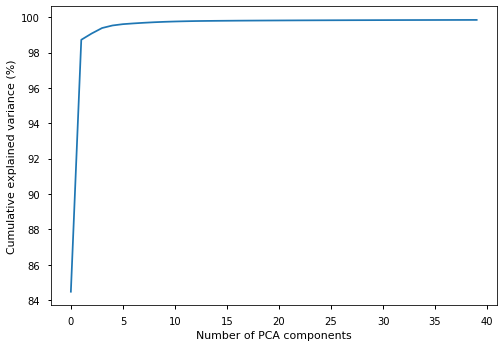

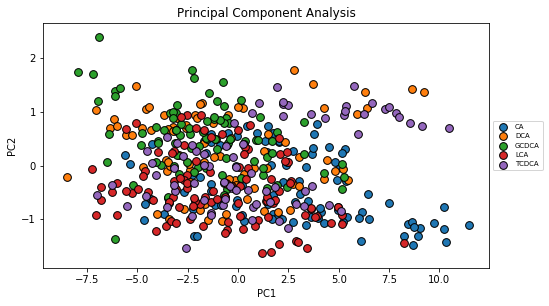

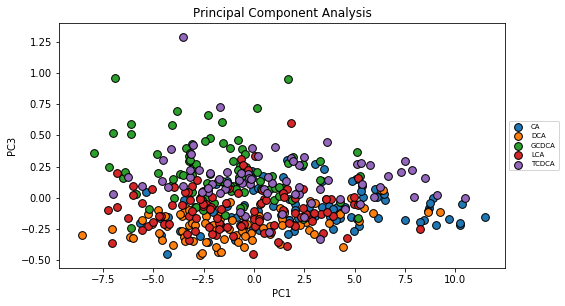

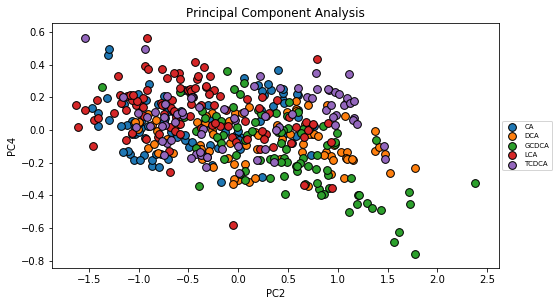

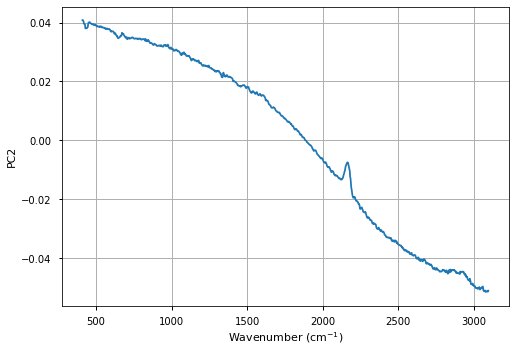

In [10]:
# Standarization with a standard scaler (For each Raman shift, mean = 0 and std = ±1 )
scaler = MinMaxScaler()  # MinMax scaler model initialization
scaler.fit(x_train_prep)  # the model is fitted on the training set

# The newly fitted scaler model is applied on train, validation and test set
x_train_sc = scaler.transform(x_train_prep)
x_val_sc = scaler.transform(x_val_prep)
x_test_sc = scaler.transform(x_test_prep)

pca_model = SpectroPCA(x_train_sc, n_comp=40)
pca_model.explained_variance()
pca_model.scatter_plot(x_test_sc, y_test, targets=classnames, comp_x=1, comp_y=2)
pca_model.scatter_plot(x_test_sc, y_test, targets=classnames, comp_x=1, comp_y=3)
pca_model.scatter_plot(x_test_sc, y_test, targets=classnames, comp_x=2, comp_y=4)

pca_model.pca_component(Wn, 1)

Model: "Conv_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 1024, 8)           48        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 8)           32        
_________________________________________________________________
activation_1 (Activation)    (None, 1024, 8)           0         
_________________________________________________________________
maxp1 (MaxPooling1D)         (None, 512, 8)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 512, 16)           656       
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 16)           64        
_________________________________________________________________
activation_2 (Activation)    (None, 512, 16)           0

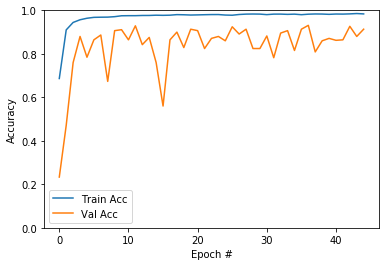

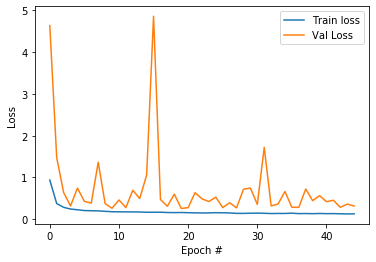

CLASSIFICATION REPPORT:

              precision    recall  f1-score   support

          CA   0.978022  0.927083  0.951872        96
         DCA   0.913580  0.870588  0.891566        85
       GCDCA   0.908163  0.988889  0.946809        90
         LCA   0.915094  0.932692  0.923810       104
       TCDCA   0.945946  0.933333  0.939597        75

    accuracy                       0.931111       450
   macro avg   0.932161  0.930517  0.930731       450
weighted avg   0.931989  0.931111  0.930937       450

CONFUSION MATRIX:

[[0.92708333 0.02083333 0.05208333 0.         0.        ]
 [0.01176471 0.87058824 0.02352941 0.08235294 0.01176471]
 [0.         0.         0.98888889 0.01111111 0.        ]
 [0.00961538 0.01923077 0.00961538 0.93269231 0.02884615]
 [0.         0.04       0.01333333 0.01333333 0.93333333]]


In [11]:
cnn = CnnBeta(x_train_sc, y_train_aug, 5, architecture='Conv_Model')
cnn.compile_model(optimizer='Adam', learning_rate=0.001)
cnn.print_model_sumary()

time_check = time.strftime("_%d_%H_%M")
cnn.config_earlystopping(epoch=25, best_weights=True)
#cnn.config_modelcheckpoint(verbose=2)

cnn.train_model(x_val_sc, y_val, b_s=132, ep=50)
lab = np.argmax(y_test, axis=1)
# save_path='report/CR'+time_check+'.txt'
print('CLASSIFICATION REPPORT:\n')
print(cnn.get_classif_report(x_test_sc, lab, class_names=classnames))
print('CONFUSION MATRIX:\n')
print(cnn.get_conf_matrix(x_test_sc, lab, class_names=classnames))


Model: "Conv_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 1024, 8)           48        
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024, 8)           32        
_________________________________________________________________
activation_7 (Activation)    (None, 1024, 8)           0         
_________________________________________________________________
maxp1 (MaxPooling1D)         (None, 512, 8)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 512, 16)           656       
_________________________________________________________________
batch_normalization_7 (Batch (None, 512, 16)           64        
_________________________________________________________________
activation_8 (Activation)    (None, 512, 16)           0

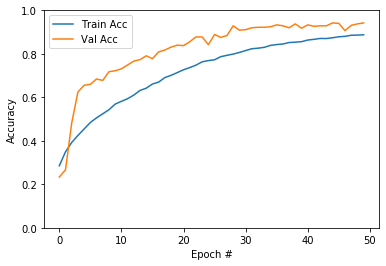

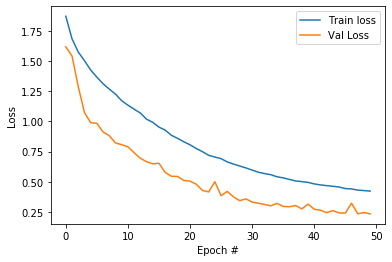

CLASSIFICATION REPPORT:

              precision    recall  f1-score   support

          CA   0.947917  0.947917  0.947917        96
         DCA   0.927711  0.905882  0.916667        85
       GCDCA   0.977011  0.944444  0.960452        90
         LCA   0.923077  0.923077  0.923077       104
       TCDCA   0.887500  0.946667  0.916129        75

    accuracy                       0.933333       450
   macro avg   0.932643  0.933597  0.932848       450
weighted avg   0.934109  0.933333  0.933482       450

CONFUSION MATRIX:

[[0.94791667 0.02083333 0.         0.01041667 0.02083333]
 [0.01176471 0.90588235 0.02352941 0.04705882 0.01176471]
 [0.01111111 0.01111111 0.94444444 0.02222222 0.01111111]
 [0.01923077 0.00961538 0.         0.92307692 0.04807692]
 [0.01333333 0.02666667 0.         0.01333333 0.94666667]]


In [12]:
cnn2 = CnnBeta(x_train_sc, y_train_aug, 5, architecture='Conv_Model')
cnn2.compile_model(optimizer='SGD', learning_rate=0.0001)
cnn2.print_model_sumary()

time_check = time.strftime("_%d_%H_%M")
cnn2.config_earlystopping(epoch=25, best_weights=True)
#cnn.config_modelcheckpoint(verbose=2)

cnn2.train_model(x_val_sc, y_val, b_s=132, ep=50)
lab = np.argmax(y_test, axis=1)
# save_path='report/CR'+time_check+'.txt'
print('CLASSIFICATION REPPORT:\n')
print(cnn2.get_classif_report(x_test_sc, lab, class_names=classnames))
print('CONFUSION MATRIX:\n')
print(cnn2.get_conf_matrix(x_test_sc, lab, class_names=classnames))

Model: "Conv_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 1024, 8)           48        
_________________________________________________________________
batch_normalization_11 (Batc (None, 1024, 8)           32        
_________________________________________________________________
activation_13 (Activation)   (None, 1024, 8)           0         
_________________________________________________________________
maxp1 (MaxPooling1D)         (None, 512, 8)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 512, 16)           656       
_________________________________________________________________
batch_normalization_12 (Batc (None, 512, 16)           64        
_________________________________________________________________
activation_14 (Activation)   (None, 512, 16)           0

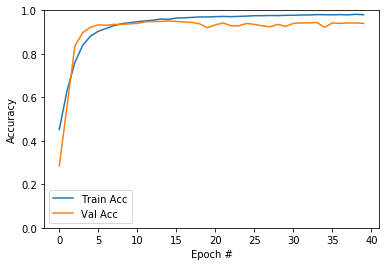

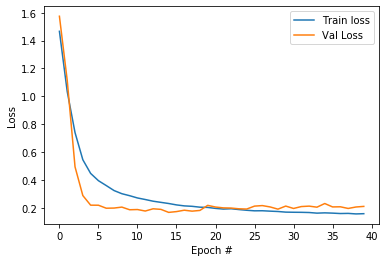

CLASSIFICATION REPPORT:

              precision    recall  f1-score   support

          CA   0.989247  0.958333  0.973545        96
         DCA   0.963855  0.941176  0.952381        85
       GCDCA   0.988506  0.955556  0.971751        90
         LCA   0.926606  0.971154  0.948357       104
       TCDCA   0.935897  0.973333  0.954248        75

    accuracy                       0.960000       450
   macro avg   0.960822  0.959911  0.960057       450
weighted avg   0.960934  0.960000  0.960151       450

CONFUSION MATRIX:

[[0.95833333 0.01041667 0.01041667 0.01041667 0.01041667]
 [0.         0.94117647 0.         0.05882353 0.        ]
 [0.01111111 0.01111111 0.95555556 0.01111111 0.01111111]
 [0.         0.         0.         0.97115385 0.02884615]
 [0.         0.01333333 0.         0.01333333 0.97333333]]


In [13]:
cnn3 = CnnBeta(x_train_sc, y_train_aug, 5, architecture='Conv_Model')
cnn3.compile_model(optimizer='Adam', learning_rate=0.0001)
cnn3.print_model_sumary()

time_check = time.strftime("_%d_%H_%M")
cnn3.config_earlystopping(epoch=25, best_weights=True)
#cnn.config_modelcheckpoint(verbose=2)

cnn3.train_model(x_val_sc, y_val, b_s=132, ep=50)
lab = np.argmax(y_test, axis=1)
# save_path='report/CR'+time_check+'.txt'
print('CLASSIFICATION REPPORT:\n')
print(cnn3.get_classif_report(x_test_sc, lab, class_names=classnames))
print('CONFUSION MATRIX:\n')
print(cnn3.get_conf_matrix(x_test_sc, lab, class_names=classnames))

Model: "Conv_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 1024, 8)           48        
_________________________________________________________________
batch_normalization_16 (Batc (None, 1024, 8)           32        
_________________________________________________________________
activation_19 (Activation)   (None, 1024, 8)           0         
_________________________________________________________________
maxp1 (MaxPooling1D)         (None, 512, 8)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 512, 16)           656       
_________________________________________________________________
batch_normalization_17 (Batc (None, 512, 16)           64        
_________________________________________________________________
activation_20 (Activation)   (None, 512, 16)           0

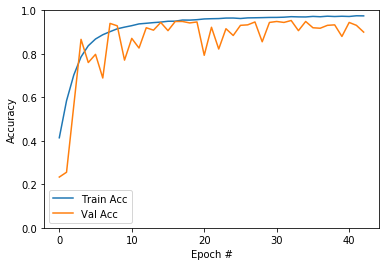

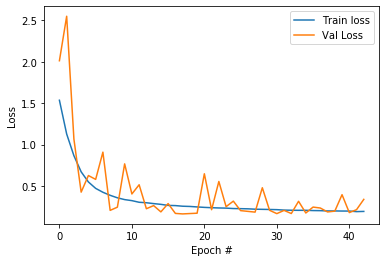

CLASSIFICATION REPPORT:

              precision    recall  f1-score   support

          CA   0.968085  0.947917  0.957895        96
         DCA   0.953488  0.964706  0.959064        85
       GCDCA   0.966667  0.966667  0.966667        90
         LCA   0.960784  0.942308  0.951456       104
       TCDCA   0.923077  0.960000  0.941176        75

    accuracy                       0.955556       450
   macro avg   0.954420  0.956319  0.955252       450
weighted avg   0.955856  0.955556  0.955596       450

CONFUSION MATRIX:

[[0.94791667 0.02083333 0.02083333 0.         0.01041667]
 [0.         0.96470588 0.01176471 0.02352941 0.        ]
 [0.02222222 0.         0.96666667 0.01111111 0.        ]
 [0.00961538 0.         0.         0.94230769 0.04807692]
 [0.         0.02666667 0.         0.01333333 0.96      ]]


In [14]:
cnn4 = CnnBeta(x_train_sc, y_train_aug, 5, architecture='Conv_Model')
cnn4.compile_model(optimizer='SGD', learning_rate=0.01)
cnn4.print_model_sumary()

time_check = time.strftime("_%d_%H_%M")
cnn4.config_earlystopping(epoch=25, best_weights=True)
#cnn.config_modelcheckpoint(verbose=2)

cnn4.train_model(x_val_sc, y_val, b_s=132, ep=50)
lab = np.argmax(y_test, axis=1)
# save_path='report/CR'+time_check+'.txt'
print('CLASSIFICATION REPPORT:\n')
print(cnn4.get_classif_report(x_test_sc, lab, class_names=classnames))
print('CONFUSION MATRIX:\n')
print(cnn4.get_conf_matrix(x_test_sc, lab, class_names=classnames))